In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load Sample Data

In [184]:
str_c = 'case'
str_d = 'death'
str_r = 'recovered'
str_dstrct = 'district'
str_date = 'date_reported'

In [102]:
df_ctr_cum = pd.read_csv('df_ctr_cum.csv')
df_ctr_cum

,date_reported,category,Number
0,2020-01-28,case,4
1,2020-01-28,recovered,4
2,2020-01-29,case,6
3,2020-01-29,recovered,6
4,2020-01-31,case,9
...,...,...,...
327,2020-06-08,case,184672
328,2020-06-08,death,8729
329,2020-06-08,recovered,170717
330,2020-06-09,case,184861


**Set prediction time frames**

In [70]:
n_training = 14
n_predict_ahead = 3

**Define Training Data**

In [231]:
# indep. var
X = pd.to_numeric(pd.to_datetime(df_ctr_cum.loc[df_ctr_cum['category']=='case'].iloc[-n_days:][str_date], format='%Y/%m/%d'))
X = X.to_numpy().reshape(-1,1)
# dep. var
y = df_ctr_cum.loc[df_ctr_cum['category']=='case'].iloc[-n_days:]['Number']
y = y.to_numpy().reshape(-1,1)

**Model**<br>
Initialize model and do training. Since the spread of a virus is (within a limited time frame) usually an exponential process, we train a linear regression model predicting the logarithm of the number of cases.

In [233]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(X,np.log(y))

print('Model fitted.')
print('Training error is {:0.2f}.'.format(mean_squared_error(y,np.exp(lr.predict(X)))))

Model fitted.
Training error is 6.69.


We quickly compare predictions and truth visually.

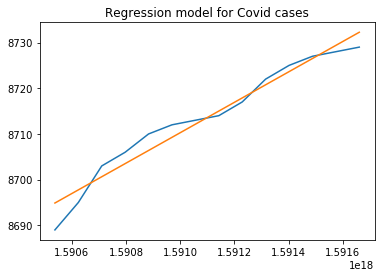

In [236]:
plt.plot(X.reshape(-1),y.reshape(-1))
plt.plot(X.reshape(-1),y_hat.reshape(-1))
plt.title('Regression model for Covid cases')
plt.show()

**Perform predictions on the next three dates.**

In [209]:
dates_to_predict = pd.Series([pd.Timestamp.today()\
                        + pd.DateOffset(idx) for idx in [1,2,3]]).dt.normalize()

predictions = np.exp(lr.predict(pd.to_numeric(pd.Series(dates_to_predict))\
           .to_numpy().reshape(-1,1)\
          ))

pd.DataFrame({'date':dates_to_predict, 'predictions':pd.Series(predictions.reshape(-1))})

,date,predictions
0,2020-06-14,8746.692484
1,2020-06-15,8749.579225
2,2020-06-16,8752.466919


**Refactor code into function that can be used in the streamlit app.**

In [198]:
def predict_days(df, n_training, n_ahead, class_to_predict,str_date='date_reported'):
    """Predict the number of Covid cases/deaths/recoverd via Linear regression
    
    df (pandas data frame): data frame containing past Covid data
    n_training (int): number of recent days used to train linear regression
    n_ahead (int): number of days to predict ahead
    class_to_predict (str): string indicating whether to predict cases, deaths,
    or recovered
    """
    # create training samples
    X = pd.to_numeric(\
            pd.to_datetime(df.loc[df['category']==class_to_predict].iloc[-n_days:][str_date],\
                            format='%Y/%m/%d'))
    #print(X)
    X = X.to_numpy().reshape(-1,1)

    # create training ground truth
    y = df.loc[df['category']==class_to_predict].iloc[-n_days:]['Number']
    y = y.to_numpy().reshape(-1,1)
    # fit linear regression based on log of y
    lr.fit(X,np.log(y))
    # dates to predict
    dates_to_predict = pd.Series([pd.Timestamp.today()\
                        + pd.DateOffset(idx) for idx in \
                                  list(np.linspace(1,n_ahead,n_ahead).astype(int))]).dt.normalize()
    #print(dates_to_predict)
    predictions = np.exp(lr.predict(pd.to_numeric(pd.Series(dates_to_predict))\
           .to_numpy().reshape(-1,1)\
          ))
    df_predicted = pd.DataFrame({'date':dates_to_predict, \
                         'predictions':pd.Series(predictions.reshape(-1))})
    df_predicted['category'] = class_to_predict
    df_predicted['predictions'] =  df_predicted['predictions'].apply(np.round).astype(int)
    return df_predicted

** Plot predictions together with current trend of the past days.**

In [238]:
import altair as alt
_width = 800
_height = 300
a = alt.Chart(df_ctr_cum[-3*14:])\
            .mark_line(point=True)\
            .encode(x=alt.X('monthdate('+str_date+'):O'),\
                    y=alt.Y('mean(Number):Q'), color='category',\
                            tooltip=['monthdate('+str_date+')',\
                                        'category','Number'])
            
b = alt.Chart(df_predicted)\
            .mark_point()\
            .encode(x=alt.X('monthdate('+'date'+'):O'),\
                    y=alt.Y('predictions:Q'), color='category',\
                            tooltip=['monthdate('+'date'+')',\
                                        'predictions'])
            
(a+b).properties(width=_width, height=_height, \
                        title='Log total cases in Germany')

alt.LayerChart(...)